## KEY VARIABLES
* Youtube_ID obviously designates the video to analyze.
* Frame step designates how many frames per second to analyze with OpenPose. Default fps is 24 frames per second.


In [0]:
YOUTUBE_ID = 'Is8tMCpv4F8'
# Frame_step also has to be set manually @ preprocessing!
FRAMESTEP = 6

# **Preparation**

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


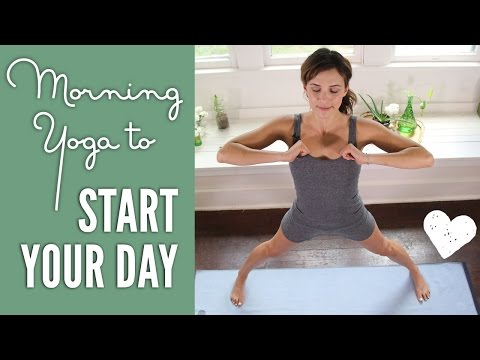

In [0]:
import time
preparation_start = time.time()

# Pick and show Youtube video
### Elderly yoga example: YOUTUBE_ID = 'kFhG-ZzLNN4'
### Default example: YOUTUBE_ID = 'nQFf38xeBww'

#Import required modules
import pandas as pd
from pandas.io.json import json_normalize
from pathlib import Path
import json
from IPython.display import YouTubeVideo
from google.colab import drive
import os
from os.path import exists, join, basename, splitext
from IPython.display import clear_output
import os
from __future__ import print_function
from __future__ import division
import cv2 as cv
import numpy as np
import argparse
import glob
import imutils
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from IPython.display import Image
import PIL
import warnings
from scipy.spatial import procrustes 
import sys
import seaborn as sns
from scipy.spatial import distance
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from scipy.signal import argrelextrema

#Options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_colwidth', -1)
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
warnings.filterwarnings("ignore", category=FutureWarning) 

#Mount google drive
drive.mount('/content/drive', force_remount=True)

YouTubeVideo(YOUTUBE_ID)

In [0]:
#install OpenPose

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # install new CMake
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose git
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies and libraries
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake -DBUILD_PYTHON=ON .. && make -j`nproc`
  clear_output()
  print("Installation done!")
else:
  print("Already installed!")

Installation done!


In [0]:
#Clear folders and download new youtube video.
!rm -rf "/content/drive/My Drive/Thesis/"

!youtube-dl -f 'bestvideo[ext=mp4]' --write-auto-sub --output "/content/drive/My Drive/Thesis/youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
preparation_end = time.time()

[youtube] Is8tMCpv4F8: Downloading webpage
[youtube] Is8tMCpv4F8: Downloading video info webpage
[youtube] Is8tMCpv4F8: Looking for automatic captions
[info] Writing video subtitles to: /content/drive/My Drive/Thesis/youtube.en.vtt
[download] Destination: /content/drive/My Drive/Thesis/youtube.mp4
[download] 100% of 131.52MiB in 00:25


In [0]:
#Inject timecode into video

!ffmpeg -i '/content/drive/My Drive/Thesis/youtube.mp4' -vf "drawtext=fontfile=/usr/share/fonts/truetype/DroidSans.ttf: timecode='00\:00\:00\:00': fontsize=65: r=23.98: \ x=(w-tw)/2: y=h-(2*lh): fontcolor=white: box=1: boxcolor=0x00000000@1" -an -y '/content/drive/My Drive/Thesis/youtube_timecode.mp4'


ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

# **Preprocessing**

In [0]:
preprocessing_start = time.time()
#Use openpose to analyse video, export frames and export json with coordinates.

#Full analysis
!cd openpose && ./build/examples/openpose/openpose.bin --video "/content/drive/My Drive/Thesis/youtube_timecode.mp4" --write_json "/content/drive/My Drive/Thesis/json_output/" --write_images "/content/drive/My Drive/Thesis/jpg_output/" --display 0 --number_people_max 1  --render_pose 1 --frame_step 6 --write_video "/content/drive/My Drive/Thesis/openpose.avi.mp4"


#JSON Only
#!cd openpose && ./build/examples/openpose/openpose.bin --video "/content/drive/My Drive/Thesis/youtube.mp4" --write_json "/content/drive/My Drive/Thesis/json_output/" --display 0 --number_people_max 1  --frame_step 100 --render_pose 0

/bin/bash: ./build/examples/openpose/openpose.bin: No such file or directory


In [0]:
#Process created json coordinates to dataframe to prep for analysis.

pathlist = Path('/content/drive/My Drive/Thesis/json_output/').glob('**/*.json')
posedata = []
num_files = sum([len(files) for r, d, files in os.walk('/content/drive/My Drive/Thesis/json_output/')])
filename = []
imagename = []

j = 0
for file in pathlist:
  j += 1
  print('File ', j, ' of ', num_files)
  image = str(file).replace("_keypoints.json", "_rendered.png").replace("json_output", "jpg_output")
  data = pd.read_json(file)
  datapeople = data['people'].to_json(orient='split')

  if datapeople == '{"name":"people","index":[],"data":[]}':
    continue

  else:
    posedata.append(datapeople)
    df = pd.DataFrame(posedata, columns=['rawposedata'])
    df2 = pd.io.json.json_normalize(df['rawposedata'].apply(json.loads))
    new_df = pd.concat([pd.DataFrame(json_normalize(x)) for x in df2['data']],ignore_index=True)
    new_df['filename'] = file

    try:
      poseinformation = pd.DataFrame(new_df['pose_keypoints_2d'].values.tolist())
      filename.append(file)
      imagename.append(image)
    except KeyError:
      continue
    if j % 500 == 0:
      clear_output()
      poseinformation['Filename'] = filename
      poseinformation['Imagename'] = imagename
      poseinformation.to_csv(path_or_buf='/content/drive/My Drive/Thesis/Poseinformation/json_preprocessed_'+(time.strftime("%H-%M|%d-%m-%Y"))+'.csv')
      poseinformation = poseinformation.iloc[0:0]
      new_df = new_df.iloc[0:0]
      df2 = df2.iloc[0:0]
      df = df.iloc[0:0]
      filename = []
      imagename = []
      posedata = []
      clear_output()

In [0]:
path = r'/content/drive/My Drive/Thesis/Poseinformation/'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

poseinformation = pd.concat(li, axis=0, ignore_index=True)

print(poseinformation.shape)
print(len(filename))


preprocessing_end = time.time()   
poseinformation.head()

ValueError: ignored